In [32]:
!pip -q install langchain-groq duckduckgo-search
!pip -q install -U langchain_community tiktoken langchainhub
!pip -q install -U langchain langgraph langchain-tavily
!pip -q install -U langfuse dotenv


In [2]:
import os
from google.colab import userdata
from pprint import pprint

os.environ["GROQ_API_KEY"] = userdata.get('GROQ_API_KEY')
os.environ["TAVILY_API_KEY"] = userdata.get('TAVILY_API_KEY')

from langchain_groq import ChatGroq

llm = ChatGroq(
    model="llama-3.1-8b-instant",     # llama-3.3-70b-versatile
)

In [3]:
from langfuse import observe, get_client
from langfuse.langchain import CallbackHandler


os.environ["LANGFUSE_PUBLIC_KEY"]=userdata.get("LANGFUSE_PUBLIC_KEY")
os.environ["LANGFUSE_SECRET_KEY"]=userdata.get("LANGFUSE_SECRET_KEY")
os.environ["LANGFUSE_HOST"]=userdata.get("LANGFUSE_HOST")


langfuse = get_client()

# Initialize Langfuse CallbackHandler for Langchain (tracing)
langfuse_handler = CallbackHandler()

# Verify connection
if langfuse.auth_check():
    print("Langfuse client is authenticated and ready!")
else:
    print("Authentication failed. Please check your credentials and host.")

Langfuse client is authenticated and ready!


1. Retrieve the incoming email.

2. Categorize the email into one of the following types:

          Sales
          Custom Inquiry
          Off-topic
          Customer Complaint

3. Generate keywords for relevant research based on the email category and content.

4. Draft a reply using researched information.

5. Validate the draft reply.

6. Rewrite the reply if necessary.

In [89]:
from langchain.prompts import PromptTemplate

from langchain_core.output_parsers import StrOutputParser
from langchain_core.output_parsers import JsonOutputParser


### Utility tool : Save output

In [72]:
def write_markdown_file(content, filename):
    """Writes the given content as a markdown file to the local directory.

    Args:
        content: The string content to write to the file.
        filename: The filename to save the file as.
    """
    with open(f"{filename}.md", "w") as f:
        f.write(str(content))

In [74]:
# import json
# import ast
# import re

# def safe_str_to_dict(s: str):
#     """
#     Safely convert a string to a Python dictionary.
#     Handles both JSON strings and Python dict-like strings.
#     """
#     if not isinstance(s, str):
#         raise TypeError("Input must be a string")

#     # First, try JSON directly (most common case)
#     try:
#         return json.loads(s)
#     except json.JSONDecodeError:
#         pass

#     # Try to clean up the string - strip whitespace and try again
#     try:
#         cleaned = s.strip()
#         return json.loads(cleaned)
#     except json.JSONDecodeError:
#         pass

#     # Try ast.literal_eval on original string
#     try:
#         return ast.literal_eval(s)
#     except (SyntaxError, ValueError):
#         pass

#     # Try to extract JSON/dict pattern if embedded in other text
#     try:
#         # Look for dictionary pattern
#         match = re.search(r'\{.*\}', s, re.DOTALL)
#         if match:
#             dict_str = match.group(0)
#             # Try JSON first
#             try:
#                 return json.loads(dict_str)
#             except json.JSONDecodeError:
#                 # Then try literal_eval
#                 try:
#                     return ast.literal_eval(dict_str)
#                 except (SyntaxError, ValueError):
#                     pass
#     except Exception:
#         pass

#     # Last resort: try to parse with more lenient JSON decoder
#     try:
#         # Use json.JSONDecoder with strict=False
#         decoder = json.JSONDecoder(strict=False)
#         return decoder.decode(s)
#     except json.JSONDecodeError:
#         pass

#     raise ValueError(f"String could not be parsed into a dictionary. String preview: {s[:200]}")

## Design Basic Chain

**Categorize Email** : Identify the type of email(e.g., sales,custom inquiry,etc.)

**Research Router** : Direct the email’s context to the appropriate search method.

**Search Keywords**: Extract relevant keywords for gathering additional information.

**Write Draft Email** : Use the research and email context to generate a thoughtful reply.

**Rewrite Router** : Determine if the draft requires rewriting or further improvement.

**Draft Email Analysis** : Evaluate the draft’s coherence, relevance, and tone.

**Rewrite Email** : Finalize the email by refining its tone and content.

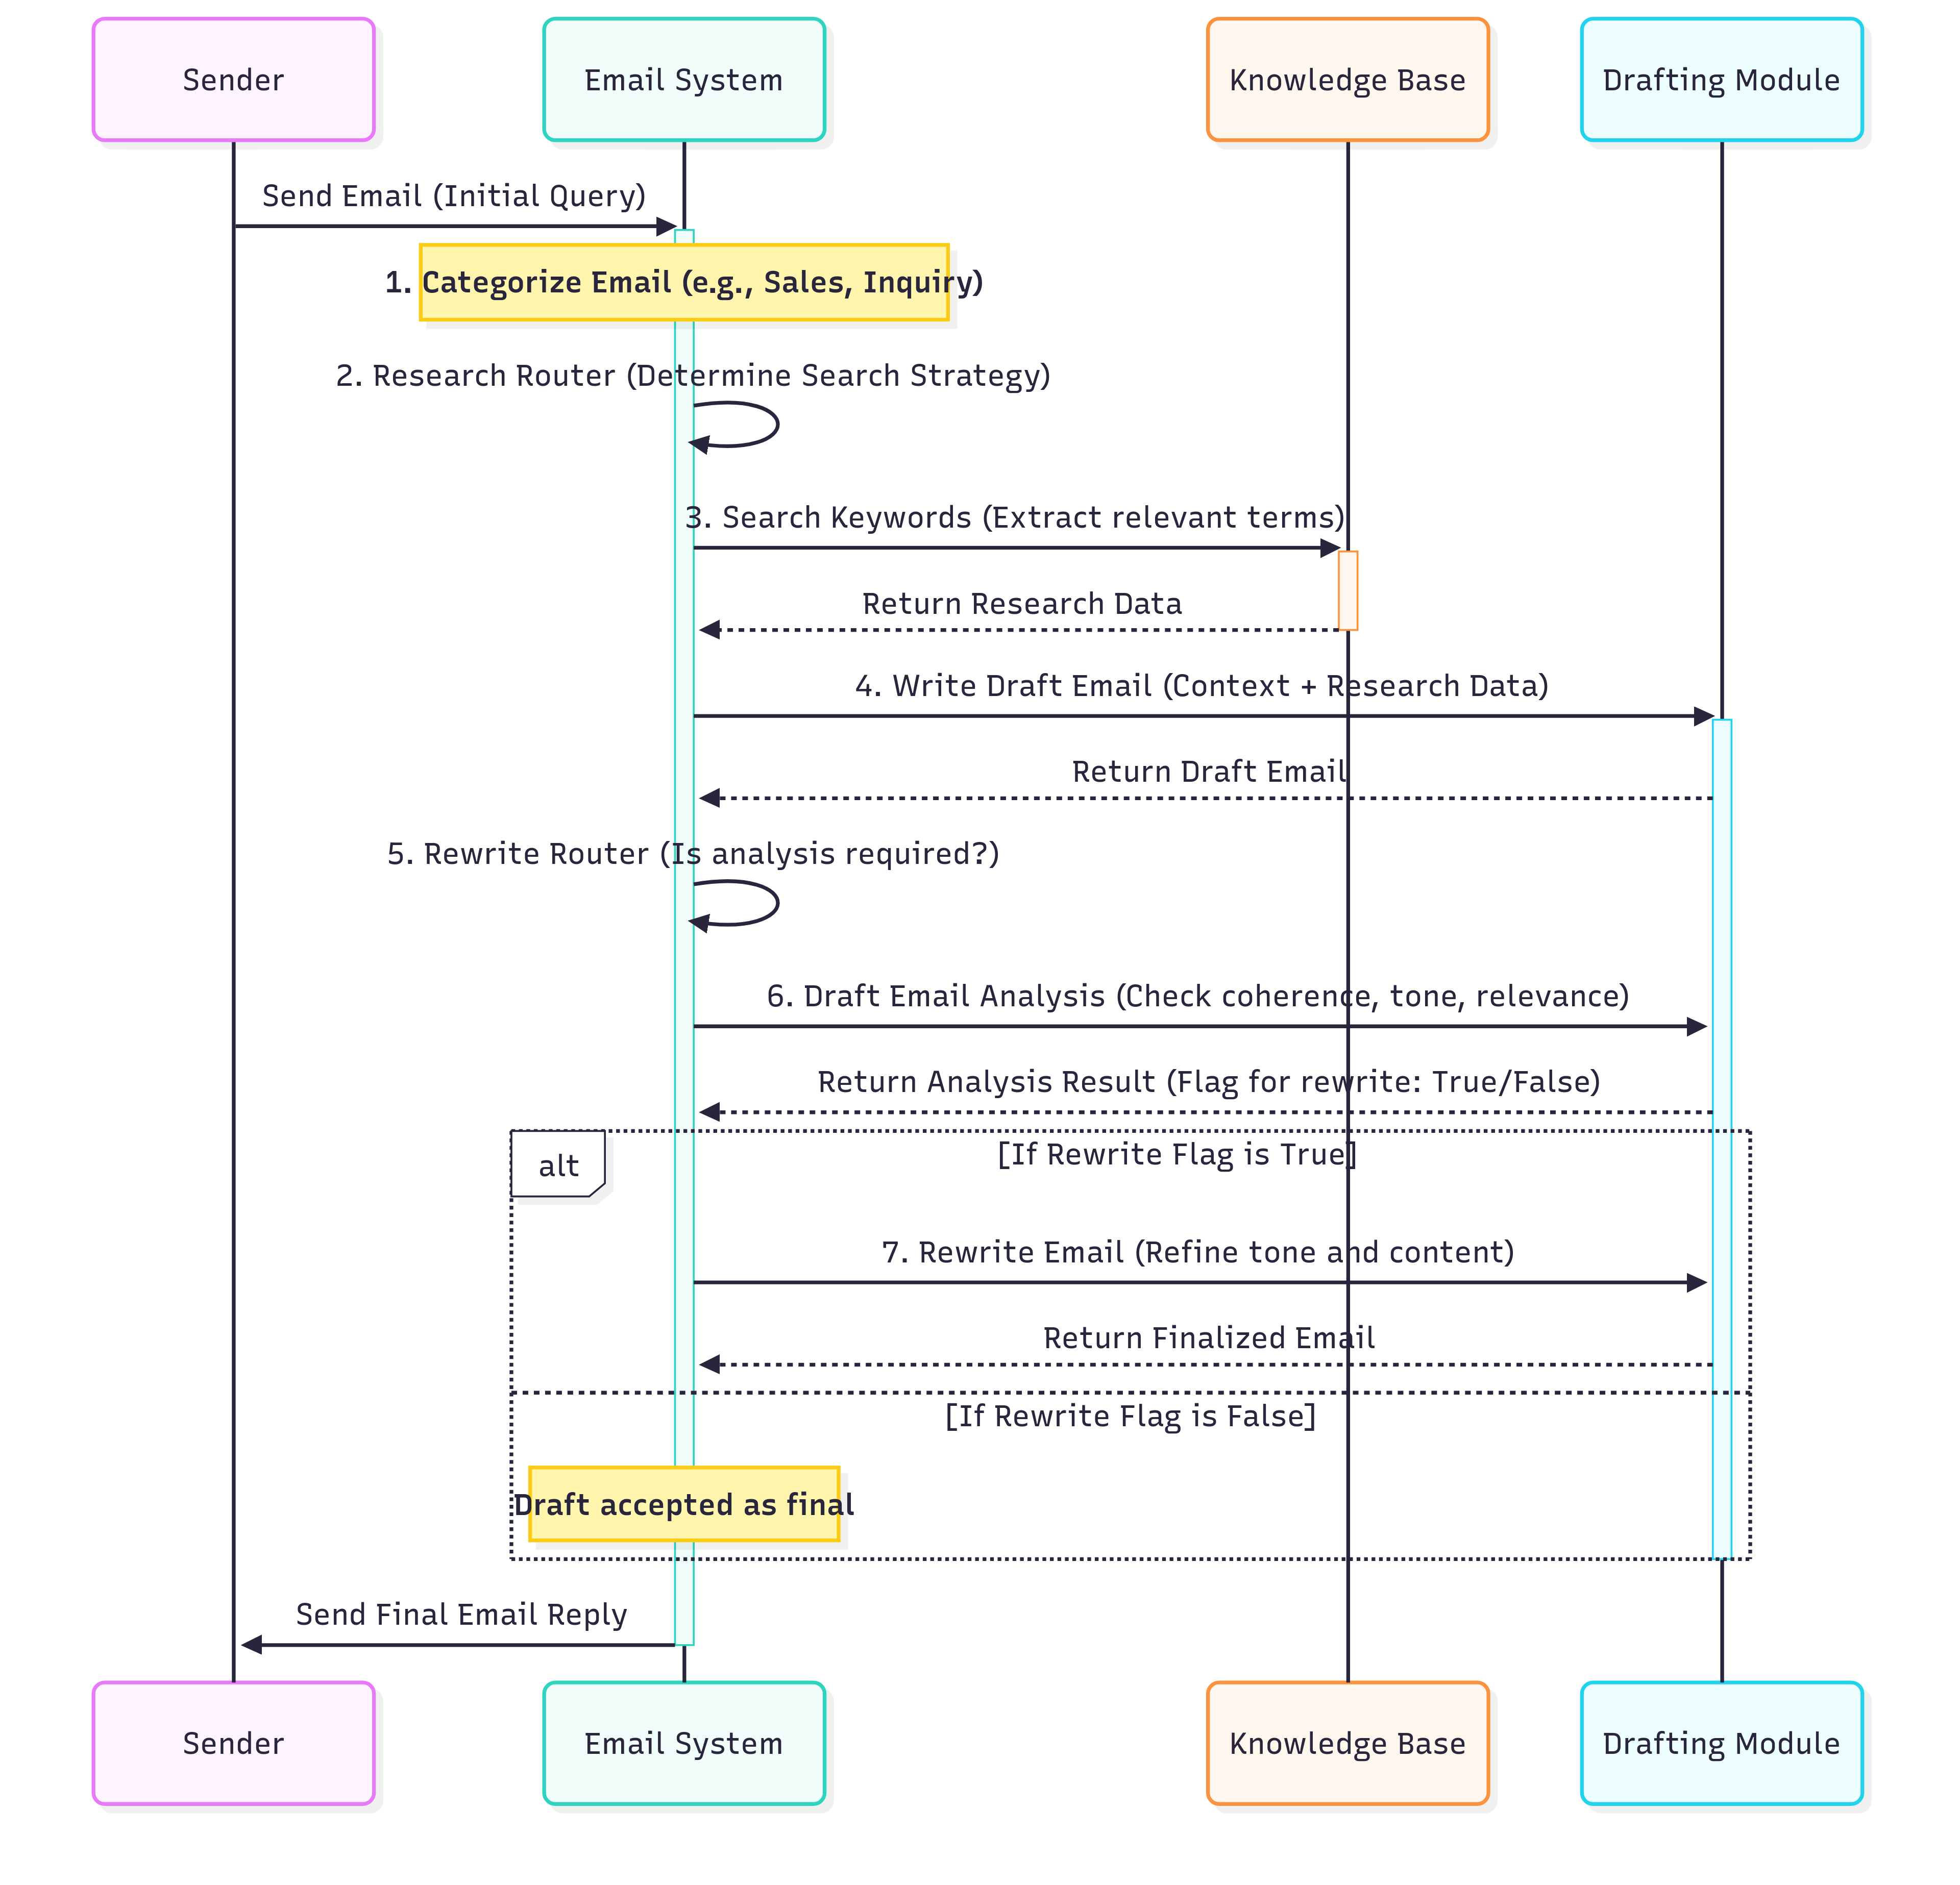

#### Categorizing Emails

    price_enquiry : Questions related to pricing.
    customer_complaint: Issues or grievances.
    product_enquiry: Questions about features, benefits , or services(excluding pricing).
    customer_feedback : General feedback about a product or service.
    off_topic : Emails that don’t it any other category.

In [90]:

template = langfuse.get_prompt("categorizing_email")
prompt = PromptTemplate.from_template(
    template.get_langchain_prompt(),
    metadata={"langfuse_prompt": template},
    )

email_category_generator = prompt | llm | StrOutputParser()



In [20]:
EMAIL = """HI there, \n
I am emailing to say that I had a wonderful stay at your resort last week. \n

I really appreciate what your staff did.

Thanks,
Paul
"""

result = email_category_generator.invoke({"initial_email": EMAIL},
                                         config={"callbacks": [langfuse_handler]})
print(result)

customer_feedback


#### Designing a Research Router

The Research Router Prompt evaluates the initial email and its assigned category to decide between two actions:

    draft_email : For simple responses that don’t require additional research.
    research_info : For cases requiring additional context or data.

In [91]:

template = langfuse.get_prompt("research_router")
prompt = PromptTemplate.from_template(
    template.get_langchain_prompt(),
    metadata={"langfuse_prompt": template},
    )

research_router = prompt | llm | JsonOutputParser()



In [88]:
EMAIL = """HI there, \n
I am emailing to say that I had a wonderful stay at your resort last week. \n

I really appreciate what your staff did.

Thanks,
Paul
"""

email_category = "customer_feedback"

result = research_router.invoke({"initial_email": EMAIL, "email_category": email_category},
                                config={"callbacks": [langfuse_handler]})

print(result,type(result))

{'router_decision': 'draft_email'} <class 'dict'>


#### Generating Search Keywords

In cases where external research is required, identifying precise search keywords is critical. This step uses the email content and its assigned category to generate the most effective keywords for retrieving relevant information.

In [92]:

template = langfuse.get_prompt("generate_search_keyword")
prompt = PromptTemplate.from_template(
    template.get_langchain_prompt(),
    metadata={"langfuse_prompt": template},
    )

search_keyword_chain = prompt | llm | JsonOutputParser()



In [83]:
EMAIL = """HI there, \n
I am emailing to say that I had a wonderful stay at your resort last week. \n

I really appreciate what your staff did.

Thanks,
Paul
"""

email_category = "customer_feedback"

result = search_keyword_chain.invoke({"initial_email": EMAIL, "email_category": email_category},
                                     config={"callbacks": [langfuse_handler]})

print(result,type(result))

{'keywords': ['customer', 'feedback', 'resort']} <class 'dict'>


#### Writing the Draft Email

The template includes specific instructions based on the email category to ensure appropriate responses:

    off_topic : Ask clarifying questions.
    customer_complaint : Reassure the customer and address their concerns.
    customer_feedback: Acknowledge the feedback and express gratitude.
    product_enquiry : Provide concise and friendly information based on the research.
    price_enquiry : Deliver the requested pricing information.

In [93]:

template = langfuse.get_prompt("draft_email")
prompt = PromptTemplate.from_template(
    template.get_langchain_prompt(),
    metadata={"langfuse_prompt": template},
    )

draft_writer_chain = prompt | llm | JsonOutputParser()



In [86]:

email_category = "customer_feedback"
research_info = None

result = draft_writer_chain.invoke({
    "initial_email": EMAIL,
    "email_category": email_category,
    "research_info": research_info,
})


print(result,type(result))


{'email_draft': "Dear Paul,\n\nThank you so much for taking the time to share your wonderful experience at our resort. We're thrilled to hear that you had a great stay and that our staff took good care of you. We're constantly striving to provide the best service possible and your feedback means a lot to us. If you have any suggestions on how we can improve, we'd love to hear them.\n\nThank you again for your kind words and for choosing our resort. We hope to welcome you back soon.\n\nBest regards,\nSarah, Resident Manager"} <class 'dict'>


#### Rewrite Router

The Rewrite Router Prompt evaluates the draft email against the following criteria:

    No Rewrite Required

    - The draft email provides a simple response matching the requirements.
    - The draft email addresses all concerns from the initial email.

    Rewrite Required

    - The draft email lacks information needed to address the customer’s concerns.
    - The draft email’s tone or content is inappropriate.
The response is returned in JSON format with a single key, **router_decision**.

By implementing the Rewrite Router, the system ensures that every email response meets a high standard of quality and relevance

In [94]:

template = langfuse.get_prompt("rewrite_router")
prompt = PromptTemplate.from_template(
    template.get_langchain_prompt(),
    metadata={"langfuse_prompt": template},
    )

rewrite_router = prompt | llm | JsonOutputParser()



In [95]:
email_category = "customer_feedback"
draft_email = "Yo we can't help you, best regards Sarah"

result = rewrite_router.invoke({
    "initial_email": EMAIL,
    "email_category": email_category,
    "draft_email": draft_email
},config={"callbacks":[langfuse_handler]})

print(result,type(result))


{'router_decision': 'rewrite'} <class 'dict'>


#### Draft Email Analysis

The Draft Analysis Prompt inspects the draft email using the following criteria:

  - Does the draft email adequately address the customer’s concerns based on the email category?
  - Does it align with the context and tone of the initial email?
  - Are there any specific areas where the draft can be improved (e.g., tone, clarity, completeness)?


The output is structured as a JSON object containing a single key, **draft_analysis**, with **feedback** and **suggestions**.

In [96]:
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

template = langfuse.get_prompt("draft_email_analysis")
prompt = PromptTemplate.from_template(
    template.get_langchain_prompt(),
    metadata={"langfuse_prompt": template},
    )

draft_analysis_chain = prompt | llm | JsonOutputParser()



In [97]:
email_category = "customer_feedback"
research_info = None
draft_email = "Yo we can't help you, best regards Sarah"

email_analysis = draft_analysis_chain.invoke({
    "initial_email": EMAIL,
    "email_category": email_category,
    "research_info": research_info,
    "draft_email": draft_email
},config={"callbacks":[langfuse_handler]})

pprint(email_analysis)

{'draft_analysis': {'analysis': 'The DRAFT_EMAIL does not address the '
                                "customer's issues. The customer provided a "
                                'positive experience at the resort and '
                                'expressed appreciation for the staff. The '
                                'DRAFT_EMAIL should be rewritten to '
                                'acknowledge and thank the customer for their '
                                'feedback, and possibly provide a response to '
                                'their kind words. Here are some suggestions '
                                'for improvement: \n'
                                '\n'
                                '\n'
                                '    1. Start with a positive acknowledgement '
                                "of the customer's feedback.\n"
                                '    2. Express gratitude for their '
                                'appreciation of 

#### Rewrite Email

With the Draft Analysis in place, the system ensures continuous improvement and higher quality in customer communication.

The Rewrite Email with Analysis step refines the draft email using the feedback provided in the Draft Email Analysis. This final step ensures that the email is polished and appropriate for sending to the customer.

In [98]:

template = langfuse.get_prompt("rewrite_email")
prompt = PromptTemplate.from_template(
    template.get_langchain_prompt(),
    metadata={"langfuse_prompt": template},
    )

rewrite_chain = prompt | llm | JsonOutputParser()



In [99]:
email_category = 'customer_feedback'
research_info = None
draft_email = "Yo we can't help you, best regards Sarah"

final_email = rewrite_chain.invoke({
    "initial_email": EMAIL,
    "email_category": email_category,
    "research_info": research_info,
    "draft_email": draft_email,
    "email_analysis": email_analysis
},config={"callbacks":[langfuse_handler]})

print(final_email,type(final_email))

{'final_email': "Dear Paul, \n\n\n    Thank you for taking the time to share your positive experience at our resort. It's great to hear that our staff made a good impression on you. If you have any other feedback or suggestions for us, please don't hesitate to share. \n\n\n    Best regards, \n\n\n    Sarah"} <class 'dict'>


#### State & Tool Setup

    initial_email : The content of the customer’s email.
    email_category : The category assigned to the email(e.g., sales, complaint, feedback).
    draft_email : The email generated by the system in response to the customer’s message.
    final_email : The final version of the email after revisions based on analysis.
    research_info: A list of relevant documents gathered during the research phase.
    info_needed : A boolean flag indicating if additional information is required for the email response.
    num_steps : A counter for the number of steps completed.
    draft_email_feedback : Feedback from the draft analysis stage.

In [33]:
from langchain_tavily import TavilySearch

web_search_tool = TavilySearch(k=1)

In [34]:
from langchain.schema import Document
from langgraph.graph import END, StateGraph
from typing_extensions import TypedDict
from typing import List

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        initial_email: email
        email_category: email category
        draft_email: LLM generation
        final_email: LLM generation
        research_info: list of documents
        info_needed: whether to add search info
        num_steps: number of steps
    """
    initial_email: str
    email_category: str
    draft_email: str
    final_email: str
    research_info: List[str]
    info_needed: bool
    num_steps: int
    draft_email_feedback: dict


## **Add nodes**

**Categorize email** : Uses the email_category_generator to categorize the email based on its content

**Research Info Search**: Generates keywords based on initial_email,email_category then perform TravilySearch and stores results in research_info

**Draft Email Writer**: Uses the categorized email, research info, and LLMs to generate the first draft of the email.

**Analyze Draft Email**: Reviews the draft email and provides feedback for improvements.

**Rewrite Email**: Uses the feedback to rewrite the draft email into a final version.

**No Rewrite**: If no rewrite is necessary, this node would pass the draft to the next stage without modifications.

**State Printer**: Prints or logs the current state for debugging purposes.

In [100]:
def categorize_email(state):
    """Take the initial email and categorize it"""
    print("---CATEGORIZING INITIAL EMAIL---")
    initial_email = state['initial_email']
    num_steps = int(state['num_steps'])
    num_steps += 1

    # Categorize the email
    email_category = email_category_generator.invoke({"initial_email": initial_email},
                                                     config={"callbacks":[langfuse_handler]})
    print(email_category)
    # Save category to local disk
    write_markdown_file(email_category, "email_category")

    return {"email_category": email_category, "num_steps": num_steps}


In [101]:

def research_info_search(state):
    print("---RESEARCH INFO SEARCHING---")
    initial_email = state["initial_email"]
    email_category = state["email_category"]
    research_info = state["research_info"]
    num_steps = state['num_steps']
    num_steps += 1

    # Web search for keywords
    keywords = search_keyword_chain.invoke({"initial_email": initial_email,
                                            "email_category": email_category },
                                            config={"callbacks":[langfuse_handler]})

    keywords = keywords['keywords']
    print(keywords,type(keywords))
    full_searches = []
    for keyword in keywords[:1]:  # Only taking the first keyword
        print(keyword)
        temp_docs = web_search_tool.invoke({"query": keyword},
                                            config={"callbacks":[langfuse_handler]})
        web_results = "\n".join([d["content"] for d in temp_docs])
        web_results = Document(page_content=web_results)
        if full_searches is not None:
            full_searches.append(web_results)
        else:
            full_searches = [web_results]
    print(full_searches)
    print(type(full_searches))

    return {"research_info": full_searches, "num_steps": num_steps}


In [102]:

def draft_email_writer(state):
    print("---DRAFT EMAIL WRITER---")
    ## Get the state
    initial_email = state["initial_email"]
    email_category = state["email_category"]
    research_info = state["research_info"]
    num_steps = state['num_steps']
    num_steps += 1

    # Generate draft email using the draft_writer_chain
    draft_email = draft_writer_chain.invoke({"initial_email": initial_email,
                                             "email_category": email_category,
                                             "research_info": research_info},
                                            config={"callbacks":[langfuse_handler]})
    print(draft_email,type(draft_email))

    email_draft = draft_email['email_draft']  # Extract the email draft from response
    write_markdown_file(email_draft, "draft_email")  # Save draft to a markdown file

    return {"draft_email": email_draft, "num_steps": num_steps}


In [104]:
def analyze_draft_email(state):
    print("---DRAFT EMAIL ANALYZER---")
    ## Get the state
    initial_email = state["initial_email"]
    email_category = state["email_category"]
    draft_email = state["draft_email"]
    research_info = state["research_info"]
    num_steps = state['num_steps']
    num_steps += 1

    # Generate draft email feedback using the draft_analysis_chain
    draft_email_feedback = draft_analysis_chain.invoke({"initial_email": initial_email,
                                                        "email_category": email_category,
                                                        "research_info": research_info,
                                                        "draft_email": draft_email},
                                            config={"callbacks":[langfuse_handler]})

    # Save feedback to a markdown file for later review
    write_markdown_file(str(draft_email_feedback), "draft_email_feedback")

    return {"draft_email_feedback": draft_email_feedback, "num_steps": num_steps}


In [105]:

def rewrite_email(state):
    print("---REWRITE EMAIL ---")

    # Extract necessary state variables
    initial_email = state["initial_email"]
    email_category = state["email_category"]
    draft_email = state["draft_email"]
    research_info = state["research_info"]
    draft_email_feedback = state["draft_email_feedback"]
    num_steps = state['num_steps']

    # Increment the step count
    num_steps += 1

    # Generate the final email using the rewrite_chain
    final_email = rewrite_chain.invoke({
        "initial_email": initial_email,
        "email_category": email_category,
        "research_info": research_info,
        "draft_email": draft_email,
        "email_analysis": draft_email_feedback
    },config={"callbacks":[langfuse_handler]})

    # Save the final email to a markdown file for review
    write_markdown_file(str(final_email), "final_email")

    # Return updated state with the final email and incremented steps
    return {"final_email": final_email['final_email'], "num_steps": num_steps}


In [106]:
def no_rewrite(state):
    print("---NO REWRITE EMAIL ---")
    ## Get the state
    draft_email = state["draft_email"]
    num_steps = state['num_steps']
    num_steps += 1

    # Save the draft email as final email
    write_markdown_file(str(draft_email), "final_email")

    return {"final_email": draft_email, "num_steps": num_steps}


In [107]:
def state_printer(state):
    """print the state"""
    print("---STATE PRINTER---")
    print(f"Initial Email: {state['initial_email']} \n" )
    print(f"Email Category: {state['email_category']} \n")
    print(f"Draft Email: {state['draft_email']} \n" )
    print(f"Final Email: {state['final_email']} \n" )
    print(f"Research Info: {state['research_info']} \n")
    print(f"Num Steps: {state['num_steps']} \n")

    # Check if 'info_needed' exists in the state
    info_needed = state.get('info_needed', 'N/A')
    print(f"Info Needed: {info_needed} \n")

    return

In [108]:

def route_to_research(state):
    """
    Route email to web search or not.
    Args:
        state (dict): The current graph state
    Returns:
        str: Next node to call
    """
    print("---ROUTE TO RESEARCH---")
    initial_email = state["initial_email"]
    email_category = state["email_category"]

    # Route decision based on the email category and content
    router = research_router.invoke({"initial_email": initial_email,
                                     "email_category": email_category},
                                    config={"callbacks":[langfuse_handler]})

    print(router,type(router))

    # Retrieve the router's decision
    print(router['router_decision'])

    # Routing logic
    if router['router_decision'] == 'research_info':
        print("---ROUTE EMAIL TO RESEARCH INFO---")
        return "research_info"
    elif router['router_decision'] == 'draft_email':
        print("---ROUTE EMAIL TO DRAFT EMAIL---")
        return "draft_email"


In [110]:

def route_to_rewrite(state):
    """
    Route email to rewrite or not, based on the draft email quality.
    Args:
        state (dict): The current graph state
    Returns:
        str: Next node to call (rewrite or no_rewrite)
    """
    print("---ROUTE TO REWRITE---")
    initial_email = state["initial_email"]
    email_category = state["email_category"]
    draft_email = state["draft_email"]
    research_info = state["research_info"]

    # Invoke the rewrite router to evaluate the draft email
    router = rewrite_router.invoke({"initial_email": initial_email,
                                     "email_category": email_category,
                                     "draft_email": draft_email},
                                    config={"callbacks":[langfuse_handler]})

    print(router,type(router))

    # Retrieve the router's decision
    print(router['router_decision'])

    # Routing logic based on the evaluation
    if router['router_decision'] == 'rewrite':
        print("---ROUTE TO ANALYSIS - REWRITE---")
        return "rewrite"
    elif router['router_decision'] == 'no_rewrite':
        print("---ROUTE EMAIL TO FINAL EMAIL---")
        return "no_rewrite"


#### Compile graph

In [111]:
# Define the workflow (state graph)
workflow = StateGraph(GraphState)

# Add nodes to the workflow graph
workflow.add_node("categorize_email", categorize_email)  # Categorize the email
workflow.add_node("research_info_search", research_info_search)  # Perform web search for info
workflow.add_node("state_printer", state_printer)  # Print the final state
workflow.add_node("draft_email_writer", draft_email_writer)  # Generate draft email
workflow.add_node("analyze_draft_email", analyze_draft_email)  # Analyze the draft
workflow.add_node("rewrite_email", rewrite_email)  # Rewrite the email if necessary
workflow.add_node("no_rewrite", no_rewrite)  # No rewrite needed, just finalize

# Set the entry point to the "categorize_email" node
workflow.set_entry_point("categorize_email")

# Add conditional edges based on the outcome of the categorization
workflow.add_conditional_edges(
    "categorize_email",
    route_to_research,
    {
        "research_info": "research_info_search",  # If research info needed, go to research
        "draft_email": "draft_email_writer",  # If no research needed, go to draft email generation
    },
)

# Add edges between nodes
workflow.add_edge("research_info_search", "draft_email_writer")  # After research, go to drafting

# Add conditional edges based on whether the draft email needs rewriting or not
workflow.add_conditional_edges(
    "draft_email_writer",
    route_to_rewrite,
    {
        "rewrite": "analyze_draft_email",  # If rewrite needed, go to analyze draft
        "no_rewrite": "no_rewrite",  # If no rewrite needed, go to final email
    },
)

# Add edges to finalize the email or send for rewriting
workflow.add_edge("analyze_draft_email", "rewrite_email")  # After analyzing, rewrite the email
workflow.add_edge("no_rewrite", "state_printer")  # No rewrite, finalize the email
workflow.add_edge("rewrite_email", "state_printer")  # After rewriting, finalize the email

# Finally, add the end node
workflow.add_edge("state_printer", END)

# Compile the workflow into an executable application
app = workflow.compile()


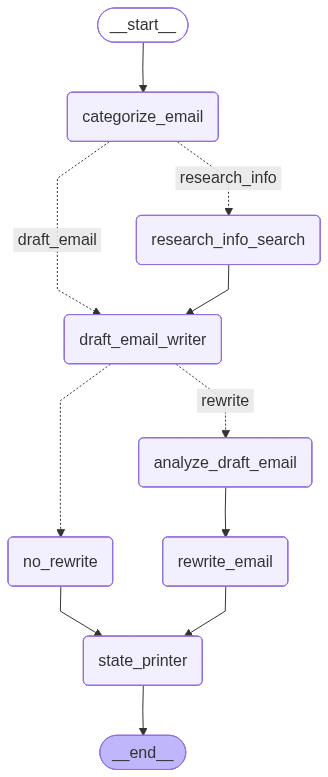

In [112]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

### Test - Customer feedback

In [113]:
EMAIL = """HI there, \n
I am emailing to say that I had a wonderful stay at your resort last week. \n


I really appreaciate what your staff did


Thanks,
Paul
"""



In [114]:
# run the agent
inputs = {
    "initial_email": EMAIL,
    "research_info": None,
    "num_steps": 0,
    "info_needed": False  # Ensure this key is added
}


for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")

---CATEGORIZING INITIAL EMAIL---
customer_feedback
---ROUTE TO RESEARCH---
{'router_decision': 'draft_email'} <class 'dict'>
draft_email
---ROUTE EMAIL TO DRAFT EMAIL---
'Finished running: categorize_email:'
---DRAFT EMAIL WRITER---
{'email_draft': "Dear Paul,\n\nThank you so much for taking the time to share your wonderful experience at our resort. We're thrilled to hear that you enjoyed your stay and that our staff were able to meet your needs.\n\nThank you for your kind words - it's always great to hear that we've made a positive impact on our guests. Your feedback is invaluable to us and will help us continue to improve our services.\n\nThank you once again for choosing our resort, and we hope to welcome you back again soon.\n\nBest regards,\nSarah\nResident Manager"} <class 'dict'>
---ROUTE TO REWRITE---
{'router_decision': 'no_rewrite'} <class 'dict'>
no_rewrite
---ROUTE EMAIL TO FINAL EMAIL---
'Finished running: draft_email_writer:'
---NO REWRITE EMAIL ---
'Finished running: no_

In [115]:
output = app.invoke(inputs)


print(output['final_email'])

---CATEGORIZING INITIAL EMAIL---
customer_feedback
---ROUTE TO RESEARCH---
{'router_decision': 'draft_email'} <class 'dict'>
draft_email
---ROUTE EMAIL TO DRAFT EMAIL---
---DRAFT EMAIL WRITER---
{'email_draft': "Dear Paul,\n\n    Thank you so much for taking the time to share your wonderful experience at our resort! We're thrilled to hear that you had a great stay and that our staff took great care of you.\n\n    Your kind words mean a lot to us, and we're glad you appreciated the efforts of our team. We're committed to providing the best possible service to our guests, and it's great to know that we're on the right track.\n\n    Thank you again for your feedback. We're looking forward to welcoming you back to our resort in the future.\n\n    Best regards,\n    Sarah\n    Resident Manager"} <class 'dict'>
---ROUTE TO REWRITE---
{'router_decision': 'no_rewrite'} <class 'dict'>
no_rewrite
---ROUTE EMAIL TO FINAL EMAIL---
---NO REWRITE EMAIL ---
---STATE PRINTER---
Initial Email: HI there

### Test - Customer complain

In [116]:


EMAIL = """HI there, \n
I am emailing to say that the resort weather was way to cloudy and overcast. \n
I wanted to write a song called 'Here comes the sun but it never came'


What should be the weather in Arizona in April?


I really hope you fix this next time.


Thanks,
George
"""


In [120]:
# run the agent
inputs = {
    "initial_email": EMAIL,
    "research_info": None,
    "num_steps": 0,
    "info_needed": False # Ensure this key is added
}


for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")

---CATEGORIZING INITIAL EMAIL---
off_topic
---ROUTE TO RESEARCH---
{'router_decision': 'draft_email'} <class 'dict'>
draft_email
---ROUTE EMAIL TO DRAFT EMAIL---
'Finished running: categorize_email:'
---DRAFT EMAIL WRITER---
{'email_draft': "Dear George,\n\nI hope this email finds you well. Thank you for reaching out to us. We're sorry to hear that the weather at the resort didn't meet your expectations during your visit.\n\nI'd love to learn more about your trip and what you were hoping for in terms of weather. Could you please tell me a bit more about your visit and what you had planned for the time you were there? Were you looking forward to a specific type of weather or outdoor activities? \n\nWe're always looking for ways to improve and appreciate your feedback.\n\nBest regards,\nSarah, Resident Manager"} <class 'dict'>
---ROUTE TO REWRITE---
{'router_decision': 'rewrite'} <class 'dict'>
rewrite
---ROUTE TO ANALYSIS - REWRITE---
'Finished running: draft_email_writer:'
---DRAFT EMA

In [121]:
output = app.invoke(inputs)


print(output['final_email'])

---CATEGORIZING INITIAL EMAIL---
'customer_complaint'
---ROUTE TO RESEARCH---
{'router_decision': 'draft_email'} <class 'dict'>
draft_email
---ROUTE EMAIL TO DRAFT EMAIL---
---DRAFT EMAIL WRITER---
{'email_draft': "Dear George,\n\nThank you for taking the time to share your concerns about your recent stay with us. We apologize for the disappointing weather conditions during your visit. We understand that the cloudy and overcast weather may have dampened your experience.\n\nWe appreciate your feedback and would like to assure you that we're taking your comments seriously. We'll do our best to ensure that the weather conditions during your next visit are more favorable.\n\nThank you for choosing our resort and for bringing this to our attention. We value your input and look forward to the opportunity to serve you better in the future.\n\nBest regards,\nSarah, Resident Manager"} <class 'dict'>
---ROUTE TO REWRITE---
{'router_decision': 'no_rewrite'} <class 'dict'>
no_rewrite
---ROUTE EMAI

In [122]:
#